In [253]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## У нас есть функция f

In [4]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

## Задание 1. Градиентный спуск для функции . Напишем функцию, выяиляющую градиент нашей функции f

In [5]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    return 2*np.sin(w)*np.cos(w)
    
    pass

In [6]:
w = np.array([1, 2])

## Проверим, что градиент считается, как надо

In [7]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"


## Реализуем градиентный спуск

In [8]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr*grad_f(curr_w)

    return np.vstack(history)

## Визуализируем точки градиентного спуска на 3D-графике нашей функции. 

In [9]:
import sys
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.gca(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

C:\Users\User\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


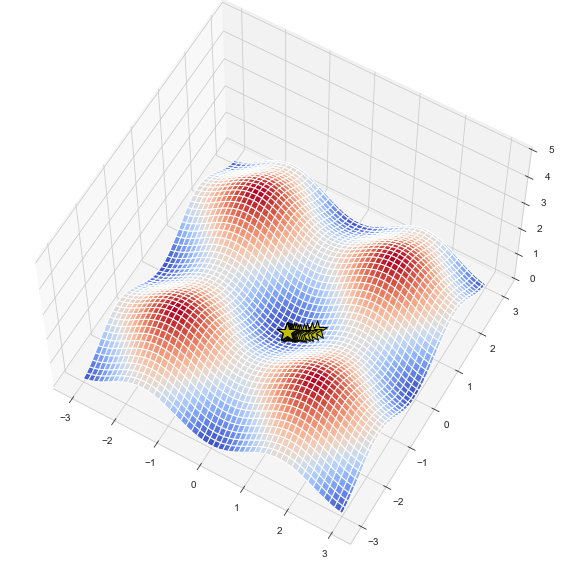

In [10]:
steps = gradient_desc_vis(f, grad_f)

## Посмотрим на зависимость значения функции от шага градиентного спуска.

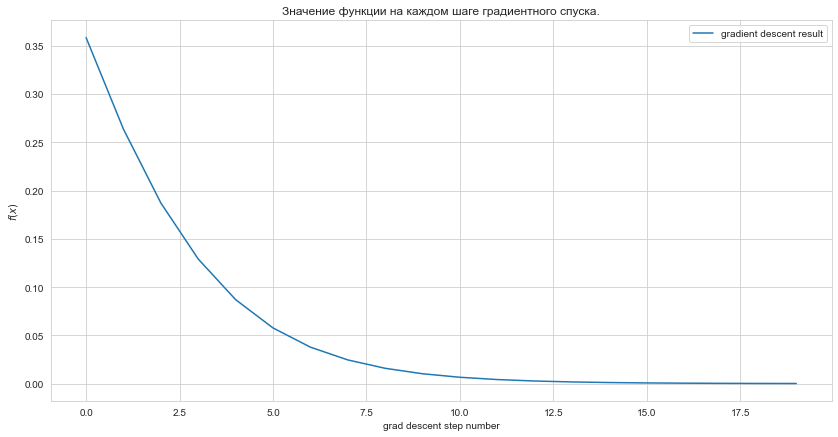

In [11]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге градиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

## Задание 2 Реализация линейной регресии
### Задание 2.1. MSE и ее градиент

In [20]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
    summa = 0
    for i in range(len(y_pred)):
      dist = (y_true[i] - y_pred[i]) ** 2
      summa += dist
    mse = (1/len(y_pred)) * (summa)
    return mse
    
    pass


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
    
    xTrans = X.transpose()
    return 2/(len(y_true)) * xTrans @ (y_pred - y_true)

    
    pass


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

## Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [13]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

## реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий

In [14]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

## Задание 2.2. Предсказания линейной регрессии 
### Реализуйте метод predict у класса CustomLinearRegression, не забудьте про свободный член!

In [15]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
        
        return X_test @ self.W    

        pass
    
    
    def __repr__(self):
        return "My custom linear regression"

## Проверим нашу реализацию на простом примере

In [16]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

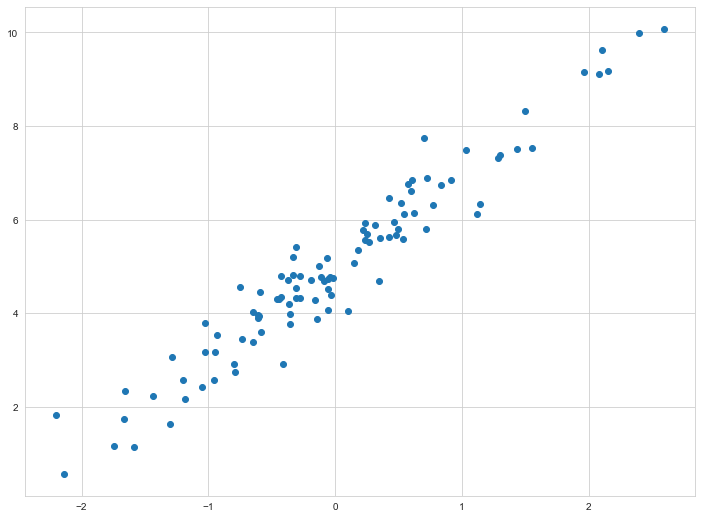

In [17]:
plt.scatter(X, y);

In [18]:
custom_lin_reg = CustomLinearRegression()

In [21]:
custom_lin_reg.fit(X, y)

My custom linear regression

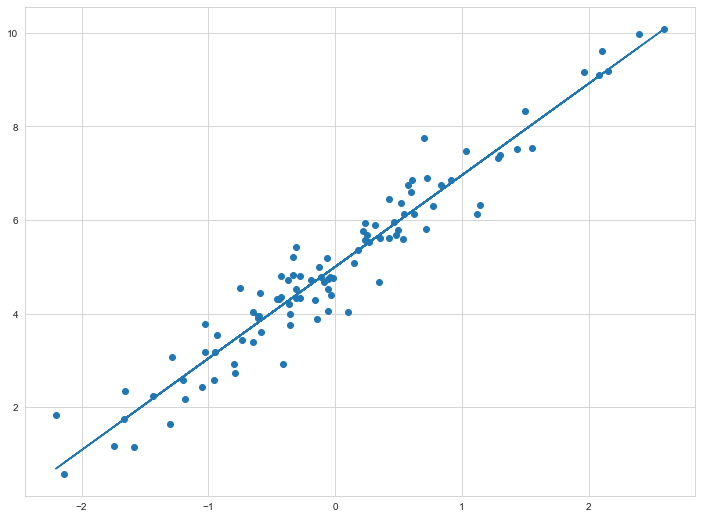

In [22]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

## Задание 2.3. Используем встроенную линейную регрессию (4 балла)

In [160]:
data = load_boston()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

C:\Users\User\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [144]:
X.shape #тут собрано 13 фичей, определяющий стоимость домов

(506, 13)

In [145]:
y.shape #тут таргетная переменная

(506,)

C:\Users\User\Miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

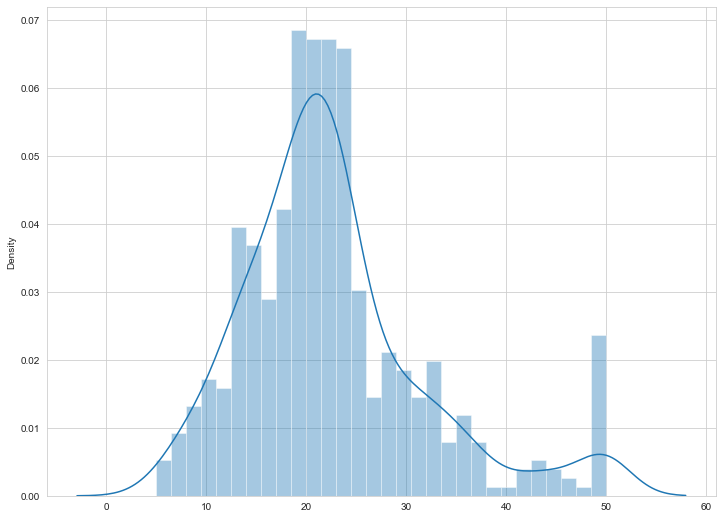

In [63]:
sns.distplot(y, bins=30) #посмотрим распределение таргетной переменной, более менее нормально с парой выбросов

In [146]:
housing = pd.DataFrame(X) #сделаем датафрейм Пандас чтобы на данные посмотреть

In [147]:
housing['target'] = y #добавим туда целевую переменную

In [66]:
housing

,0,1,2,3,4,5,6,7,8,9,10,11,12,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


<AxesSubplot:>

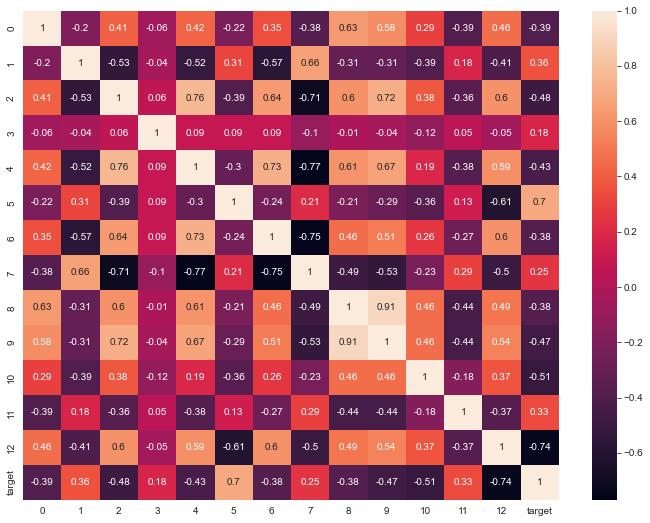

In [94]:
correlation_matrix = housing.corr().round(2) #построим матрицу корреляций и узнаем попарно все значения коэффициентов корреляций между колонками
sns.heatmap(data=correlation_matrix, annot=True) #для модели линейной регрессии есть смысл брать фичу 12, 5

In [161]:
X = pd.DataFrame(X) #сделаем X и y тоже pandas датафреймами
y = pd.DataFrame(y)
X

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [150]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=SEED) #разделим на трейн и тест

In [151]:
LinRegModel = LinearRegression()
LinRegModel.fit(X_train, y_train) #обучили модель линейной регрессии из библиотеки sklearn на трейне ,без стандартизации

LinearRegression()

In [152]:
y_pred = LinRegModel.predict(X_test) #предсказываем значения для теста

In [153]:
print("MSE", mean_squared_error(y_test, y_pred)) #узнаем основные метрики

MSE 23.894614918192094


In [154]:
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE 4.888211832377162


In [155]:
print("R2", r2_score(y_test, y_pred))

R2 0.7594226591833689


In [156]:
print("Coefficients: \n", LinRegModel.coef_) #посмотрим на коэффициенты. судя по ним, наибольший вес имеют фичи c номерами 1, 2 , 10,12

Coefficients: 
 [[-1.07121280e-01  5.14974417e-02  4.32506320e-03  2.07513462e+00
  -1.49217378e+01  3.44099225e+00 -1.09082491e-02 -1.43323659e+00
   2.78420322e-01 -1.05381209e-02 -9.28698575e-01  1.08129380e-02
  -5.39553742e-01]]


In [162]:
X = X.drop([0, 6, 9], axis='columns') #удалим колонки 6 и 9, они чет имеют небольшой вклад в модель
X

,1,2,3,4,5,7,8,10,11,12
0,18.0,2.31,0.0,0.538,6.575,4.0900,1.0,15.3,396.90,4.98
1,0.0,7.07,0.0,0.469,6.421,4.9671,2.0,17.8,396.90,9.14
2,0.0,7.07,0.0,0.469,7.185,4.9671,2.0,17.8,392.83,4.03
3,0.0,2.18,0.0,0.458,6.998,6.0622,3.0,18.7,394.63,2.94
4,0.0,2.18,0.0,0.458,7.147,6.0622,3.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...
501,0.0,11.93,0.0,0.573,6.593,2.4786,1.0,21.0,391.99,9.67
502,0.0,11.93,0.0,0.573,6.120,2.2875,1.0,21.0,396.90,9.08
503,0.0,11.93,0.0,0.573,6.976,2.1675,1.0,21.0,396.90,5.64
504,0.0,11.93,0.0,0.573,6.794,2.3889,1.0,21.0,393.45,6.48


In [163]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=SEED) #разделим на трейн и тест
X_train

,1,2,3,4,5,7,8,10,11,12
343,55.0,3.78,0.0,0.4840,6.696,5.7321,5.0,17.6,396.90,7.18
320,0.0,7.38,0.0,0.4930,6.426,4.5404,5.0,19.6,396.90,7.20
244,22.0,5.86,0.0,0.4310,5.593,7.9549,7.0,19.1,372.49,12.50
26,0.0,8.14,0.0,0.5380,5.813,4.6820,4.0,21.0,376.88,14.81
281,20.0,3.33,0.0,0.4429,6.968,5.2447,5.0,14.9,392.23,4.59
...,...,...,...,...,...,...,...,...,...,...
86,0.0,4.49,0.0,0.4490,6.015,4.4272,3.0,18.5,395.99,12.86
212,0.0,10.59,1.0,0.4890,5.807,3.6526,4.0,18.6,390.94,16.03
468,0.0,18.10,0.0,0.5800,5.926,2.9084,24.0,20.2,368.74,18.13
364,0.0,18.10,1.0,0.7180,8.780,1.9047,24.0,20.2,354.55,5.29


In [164]:
LinRegModel = LinearRegression() #cнова зададим модель и обучим на трейн и сет
LinRegModel.fit(X_train, y_train)
y_pred = LinRegModel.predict(X_test)
print("MSE", mean_squared_error(y_test, y_pred)) #посчитаем метрики, вот только не сильно они улучшились

MSE 25.529207244068566


In [165]:
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE 5.052643589653694


In [167]:
print("R2", r2_score(y_test, y_pred))

R2 0.7429651487181455


In [169]:
data = load_boston()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]
X = pd.DataFrame(data = X, columns = feature_names) #сделаем X и y тоже pandas датафреймами
y = pd.DataFrame(y)

X = StandardScaler().fit_transform(X) #попробуем стандартизировать данные
X = pd.DataFrame(data = X, columns = feature_names)
X

C:\Users\User\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.413229,-0.487722,0.115738,-0.272599,0.158124,0.439316,0.018673,-0.625796,-0.982843,-0.803212,1.176466,0.387217,-0.418147
502,-0.415249,-0.487722,0.115738,-0.272599,0.158124,-0.234548,0.288933,-0.716639,-0.982843,-0.803212,1.176466,0.441052,-0.500850
503,-0.413447,-0.487722,0.115738,-0.272599,0.158124,0.984960,0.797449,-0.773684,-0.982843,-0.803212,1.176466,0.441052,-0.983048
504,-0.407764,-0.487722,0.115738,-0.272599,0.158124,0.725672,0.736996,-0.668437,-0.982843,-0.803212,1.176466,0.403225,-0.865302


In [170]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=SEED) #разделим на трейн и тест
X_train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
343,-0.417558,1.872854,-1.073423,-0.272599,-0.610687,0.586056,-0.432946,0.920817,-0.523001,-0.227101,-0.395567,0.441052,-0.767180
320,-0.401013,-0.487722,-0.548149,-0.272599,-0.532942,0.201398,-0.578745,0.354320,-0.523001,-0.720062,0.529158,0.441052,-0.764377
244,-0.396535,0.456508,-0.769931,-0.272599,-1.068519,-0.985343,0.281821,1.977468,-0.293081,-0.464673,0.297977,0.173412,-0.021455
26,-0.342325,-0.487722,-0.437258,-0.272599,-0.144217,-0.671918,0.772557,0.421632,-0.637962,-0.601276,1.176466,0.221545,0.302346
281,-0.416206,0.370669,-1.139082,-0.272599,-0.965723,0.973563,-1.115709,0.689122,-0.523001,-1.141751,-1.643945,0.389848,-1.130230
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,-0.414480,-0.487722,-0.969827,-0.272599,-0.913029,-0.384137,-0.834781,0.300508,-0.752922,-0.957633,0.020560,0.431074,0.029007
212,-0.395242,-0.487722,-0.079780,3.668398,-0.567496,-0.680466,-0.525404,-0.067713,-0.637962,-0.779455,0.066796,0.375704,0.473358
468,1.392077,-0.487722,1.015999,-0.272599,0.218592,-0.510932,0.086238,-0.421483,1.661245,1.530926,0.806576,0.132296,0.767723
364,-0.016204,-0.487722,1.015999,3.668398,1.410682,3.555044,0.509409,-0.898611,1.661245,1.530926,0.806576,-0.023289,-1.032108


In [171]:
LinRegModel = LinearRegression() #cнова зададим модель и обучим на трейн и сет
LinRegModel.fit(X_train, y_train)
y_pred = LinRegModel.predict(X_test)
print("MSE", mean_squared_error(y_test, y_pred)) #посчитаем метрики, вот только не сильно они улучшились

MSE 23.894614918192012


In [172]:
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE 4.888211832377154


In [173]:
print("R2", r2_score(y_test, y_pred))

R2 0.7594226591833698


## Задание 3. Реализация логистической регресии 

## Задание 3.4. Применение логистической регрессии (5 баллов)

In [241]:
pokemon = pd.read_csv("Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [242]:
pokemon.loc[(pokemon.Legendary == True), 'Legendary'] = 1
pokemon.loc[(pokemon.Legendary == False), 'Legendary'] = 0

In [243]:
pokemon.Legendary

0      0
1      0
2      0
3      0
4      0
      ..
795    1
796    1
797    1
798    1
799    1
Name: Legendary, Length: 800, dtype: object

In [244]:
pokemon = pokemon.astype({'Legendary': 'int64'}) #переведем таргет в численную переменную, посмотрим остальные типы. Колонка "имя" явно не влияет на предсказание, ее можно убрать

In [245]:
pokemon.info() #в другой категориальной переменной Type2 многовато NaN, ее тоже можно не брать

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    int64 
dtypes: int64(10), object(3)
memory usage: 81.4+ KB


In [246]:
pd.unique(pokemon['Type 1']) #в переменной Type2 оч много уникальных значений, они внесут оч многокоэффициентов в модель, тоже можноубрать

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [247]:
pokemon = pokemon.drop(['Name', 'Type 1', 'Type 2'], axis='columns') 
pokemon
#дропаем колонки с категориальными переменными имени и типов

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,318,45,49,49,65,65,45,1,0
1,2,405,60,62,63,80,80,60,1,0
2,3,525,80,82,83,100,100,80,1,0
3,3,625,80,100,123,122,120,80,1,0
4,4,309,39,52,43,60,50,65,1,0
...,...,...,...,...,...,...,...,...,...,...
795,719,600,50,100,150,100,150,50,6,1
796,719,700,50,160,110,160,110,110,6,1
797,720,600,80,110,60,150,130,70,6,1
798,720,680,80,160,60,170,130,80,6,1


In [248]:
X = pokemon.drop(['Legendary'],axis='columns')
X

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
0,1,318,45,49,49,65,65,45,1
1,2,405,60,62,63,80,80,60,1
2,3,525,80,82,83,100,100,80,1
3,3,625,80,100,123,122,120,80,1
4,4,309,39,52,43,60,50,65,1
...,...,...,...,...,...,...,...,...,...
795,719,600,50,100,150,100,150,50,6
796,719,700,50,160,110,160,110,110,6
797,720,600,80,110,60,150,130,70,6
798,720,680,80,160,60,170,130,80,6


In [249]:
y = pd.DataFrame(pokemon['Legendary'])
y

,Legendary
0,0
1,0
2,0
3,0
4,0
...,...
795,1
796,1
797,1
798,1


In [250]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=SEED) #разделим на трейн и тест
X_train


,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
626,565,495,74,108,133,83,65,32,5
550,492,600,100,100,100,100,100,100,4
776,706,600,90,100,70,110,150,80,6
779,709,474,85,110,76,65,82,56,6
768,698,362,77,59,50,67,63,46,6
...,...,...,...,...,...,...,...,...,...
322,298,190,50,20,40,20,40,20,3
681,620,510,65,125,60,95,60,105,5
275,254,630,70,110,75,145,85,145,3
86,80,490,95,75,110,100,80,30,1


In [251]:
LogModel = LogisticRegression()
LogModel.fit(X_train, y_train)

C:\Users\User\Miniconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

C:\Users\User\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


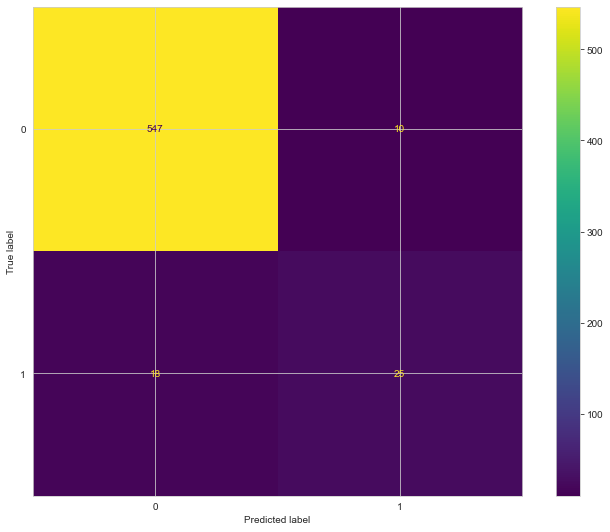

In [254]:
import sklearn
sklearn.metrics.plot_confusion_matrix(LogModel, X_train, y_train) #изобразим confusion matrix для train

C:\Users\User\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


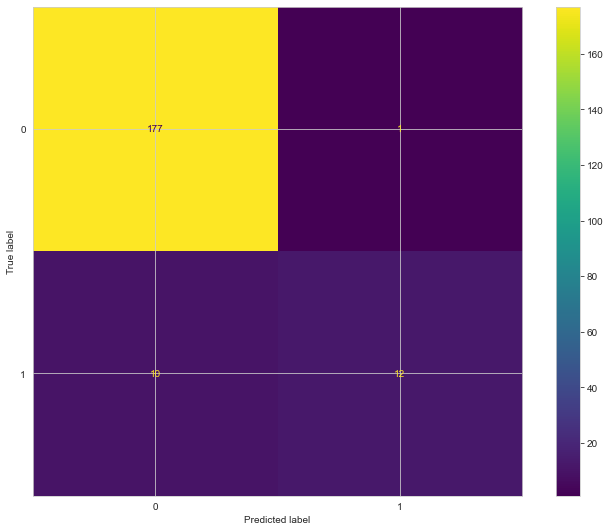

In [255]:
sklearn.metrics.plot_confusion_matrix(LogModel, X_test, y_test) ##изобразим confusion matrix для test

In [256]:
y_pred=LogModel.predict(X_test)

In [260]:
from sklearn.metrics import recall_score, precision_score

recall_score(y_test, y_pred)

0.5454545454545454

In [261]:
precision_score(y_test, y_pred)

0.9230769230769231

In [262]:
y_predicted_prob = LogModel.predict_proba(X_test) #получим предсказанные вероятности

<AxesSubplot:>

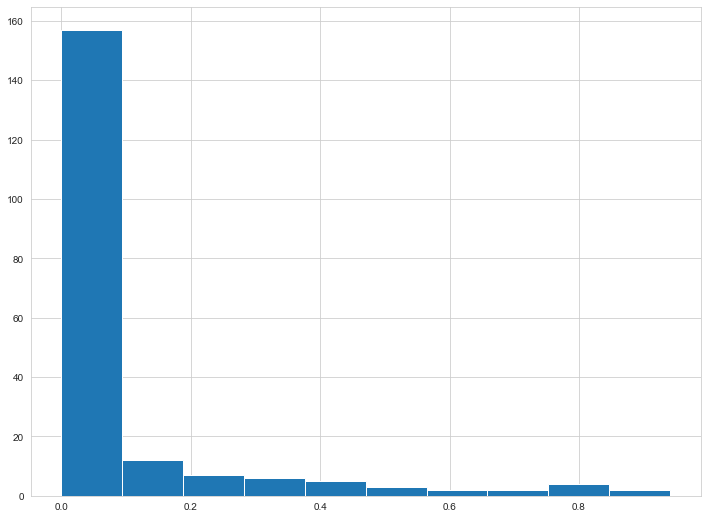

In [263]:
pd.Series(y_predicted_prob[:, 1]).hist() #изобразим

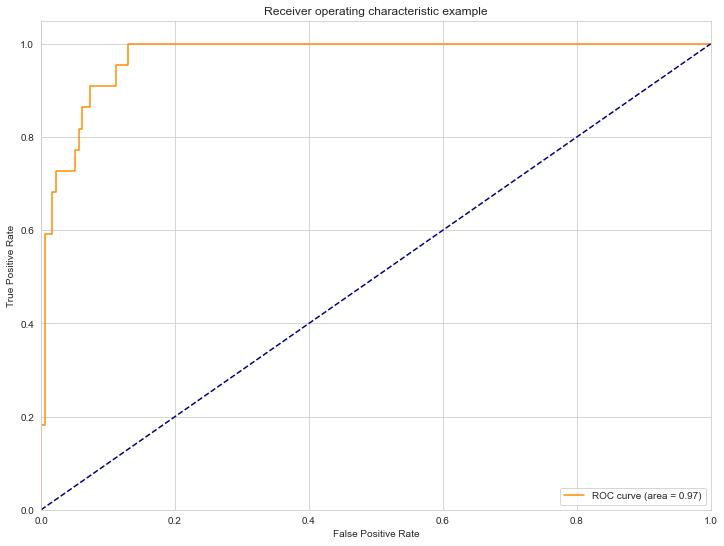

In [265]:
from sklearn.metrics import roc_curve, auc #изобразим ROC-кривую, пунктир - самый плохой вариант
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
roc_auc = auc(fpr, tpr)

In [267]:
roc_auc = auc(fpr, tpr) #площадь под кривой - все с нашей моделью ок
roc_auc

0.9731869254341164

## Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

### Это странно но ладно)  Люблю Florence and the Machine, Hozier, Kaleo, David Bowie